In [1]:
import os
import socket
import joblib
import numpy as np
import random
from Evaluation import evaluation
from Plotting import plotting as plotting_utils
from Preprocessing import preprocessing
import sys
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from sklearn import metrics

%pylab inline
%load_ext autoreload
%autoreload 2
print(socket.gethostname())

/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Populating the interactive namespace from numpy and matplotlib
ift-dgx


/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
Y_columns = {'subId': 0,
 'session': 1,
 'round': 2,
 'trial': 3}

Y_columns_judo = {'subId': 0,
 'session': 1,
 'trialId': 2,
 'seqId': 3,
 'original_trial_length_before_padding': 4}

ethnicity_mapping = {'African':'Black',
                     'African American':'Black',
                     'African-American':'Black',
                     'Asian':'Asian',
                     'Asian/White':'Mixed',
                     'Black':'Black',
                     'Black/Hispanic':'Mixed',
                     'Caucasian':'Caucasian',
                     'Caucasian/Hispanic':'Mixed',
                     'European':'Caucasian',
                     'Hiaspanic/Black/Arab':'Mixed',
                     'Hispanic':'Hispanic',
                     'Hispanic/Caucasian':'Mixed',
                     'Hispanic/Latino':'Hispanic',
                     'Hispanic/Native American':'Mixed',
                     'Hispanic/While':'Mixed',
                     'Hispanic/White':'Mixed',
                     'Latina':'Hispanic',
                     'Lau':'Mixed',
                     'Mexican':'Hispanic',
                     'Mexican American':'Mixed',
                     'Mexican/Hispanic':'Hispanic',
                     'Middle-Eastern':'Mixed', #??
                     'Mixed':'Mixed',
                     'Multiracial':'Mixed',
                     'Native American':'Mixed', #??
                     'West Indian':'Mixed',
                     'White':'Caucasian',
                     'White-Hispanic':'Mixed',
                     'White/Hispanic':'Mixed',
                     'White/Mexican':'Mixed',
                     'White/Mexican American':'Mixed',
                     'Whtie':'Caucasian'}

age_mapping = {'young_threshold':20,
               'old_threshold': 30}

### Load demographic data

In [3]:
demo_info_df = pd.read_excel('GazeBase_v2_0/GazeBaseDemoInfo.xlsx')

demo_list = ['Age',
             'Self-Identified Gender',
             'Self-Identified Ethnicity',
             'normalized Ethnicity',
             'age_class']

ethno_list = list(demo_info_df['Self-Identified Ethnicity'])
normalized_ethno_list = []
for i in range(len(ethno_list)):
    normalized_ethno_list.append(ethnicity_mapping[ethno_list[i]])
demo_info_df['normalized Ethnicity'] = list(normalized_ethno_list)

age_list = []
age = list(demo_info_df['Age'])
for i in range(len(age)):
    cur_class = 'between'
    if age[i] <= age_mapping['young_threshold']:
        cur_class = 'Age <= 20'
    if age[i] >= age_mapping['old_threshold']:
        cur_class = 'Age >= 30'
    age_list.append(cur_class)
demo_info_df['age_class'] = list(age_list)

demo_dict = dict()
for i in range(len(demo_info_df)):
    cur_line = demo_info_df.iloc[i]
    cur_part = cur_line['Participant ID']
    for demo_type in demo_list:
        if demo_type not in demo_dict:
            demo_dict[demo_type] = dict()
        demo_dict[demo_type][cur_part] = cur_line[demo_type]

In [4]:
demo_info_df.head()

,Participant ID,Age,Self-Identified Gender,Self-Identified Ethnicity,normalized Ethnicity,age_class
0,1,30,Male,Hispanic,Hispanic,Age >= 30
1,2,18,Male,White,Caucasian,Age <= 20
2,3,19,Male,Mixed,Mixed,Age <= 20
3,4,19,Female,Hispanic,Hispanic,Age <= 20
4,5,22,Male,White,Caucasian,between


In [5]:
from sklearn.manifold import TSNE

joblib_path = 'plots/t-sne_data.joblib'

if os.path.exists(joblib_path):
    joblib_data = joblib.load(joblib_path)
    embeddings=joblib_data['embeddings']
    Y_test=joblib_data['Y_test']
    train_user=joblib_data['train_user']
    test_user=joblib_data['test_user']
    X_reduced = joblib_data['X_reduced']
else:
    embedding_path = "saved_embeddings/key_random_trials_['TEX',_'BLG',_'FXS',_'HSS',_'RAN',_'VD1',_'VD2']_fold_0_percentage_1_seconds_per_user_80.npz"
    embedding_data = np.load(embedding_path)
    embeddings=embedding_data['embeddings']
    Y_test=embedding_data['Y_test']
    train_user=embedding_data['train_user']
    test_user=embedding_data['test_user']

    n_components = 2
    random_state = 42

    X_reduced = TSNE(n_components=n_components, init="pca", random_state=random_state).fit_transform(embeddings)

    joblib.dump({'embeddings':embeddings,
                 'Y_test':Y_test,
                 'train_user':train_user,
                 'test_user':test_user,
                 'X_reduced':X_reduced},'plots/t-sne_data.joblib',
               compress=3,protocol=2)

plt.figure(figsize=(10,10))
plt.scatter(X_reduced[:,0],X_reduced[:,1])
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: "saved_embeddings/key_random_trials_['TEX',_'BLG',_'FXS',_'HSS',_'RAN',_'VD1',_'VD2']_fold_0_percentage_1_seconds_per_user_80.npz"

### Visualize by Gender

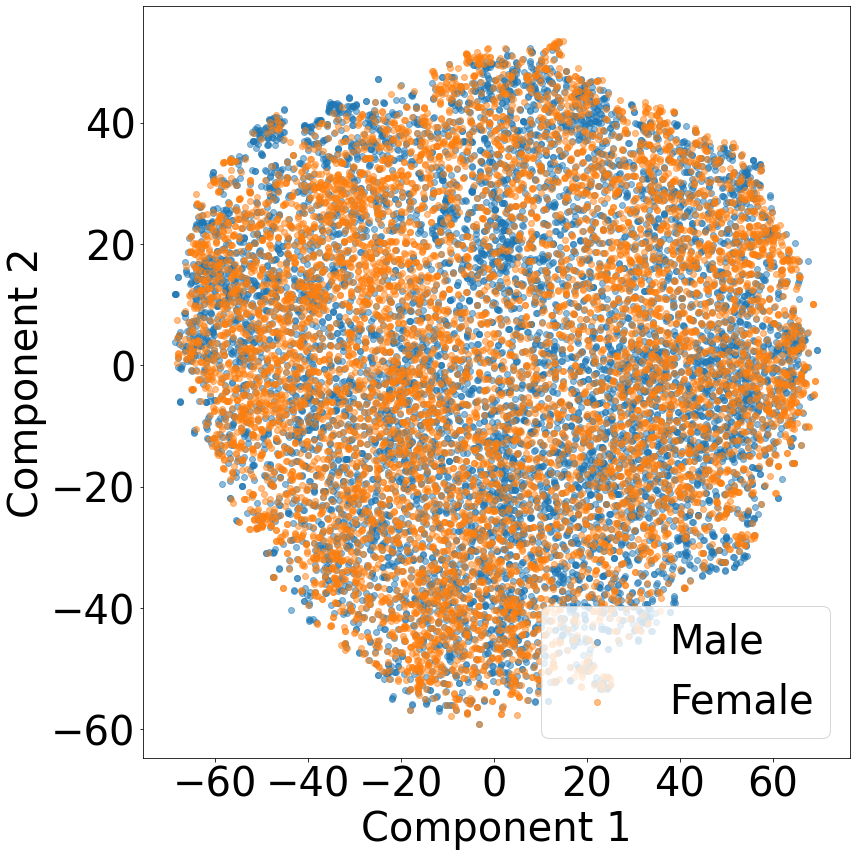

In [6]:
cur_key = 'gender'
use_label = ['Male','Female']
plt.figure(figsize=(12,12))
fontsize=40
label = []
test_user_ids = Y_test[:,Y_columns['subId']]
for user in test_user_ids:
    cur_label = demo_dict['Self-Identified Gender'][user]
    label.append(cur_label)
label = np.array(label)
for c_label in use_label:
    cur_ids = np.where(label == c_label)[0]
    plt.scatter(X_reduced[cur_ids,0],X_reduced[cur_ids,1], label = c_label,alpha=0.5)
plt.legend(fontsize=fontsize)
plt.xlabel('Component 1',fontsize=fontsize)
plt.ylabel('Component 2',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig('plots/' + cur_key + '_t_sne.pdf')
plt.show()

### Visualize by Ethnicity

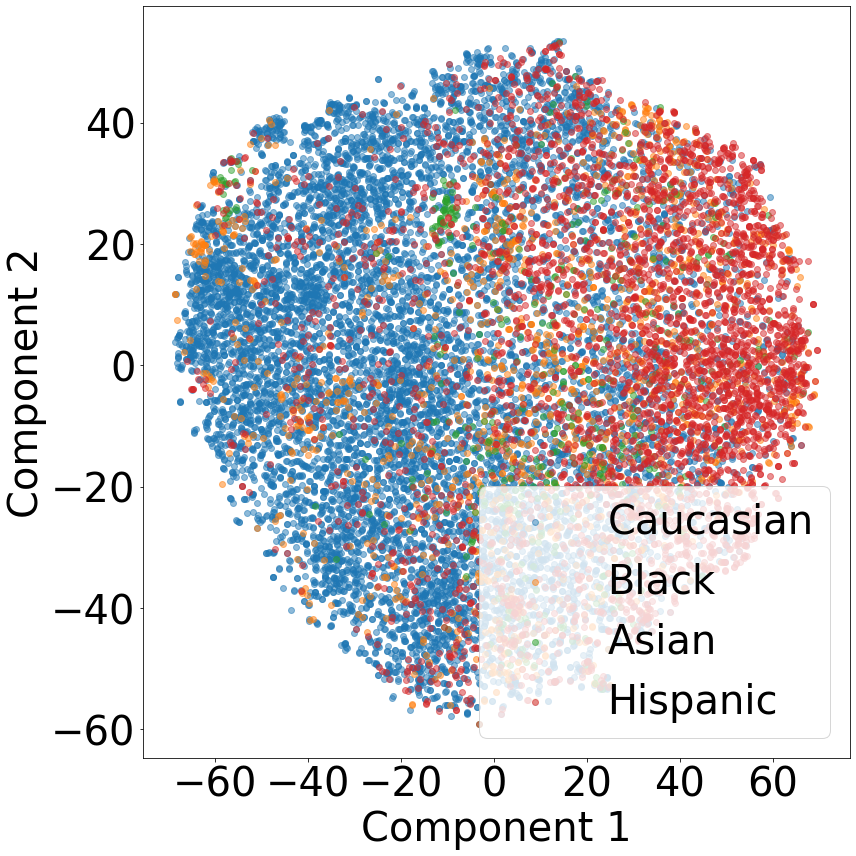

In [7]:
cur_key = 'ethnicity'
use_label = ['Caucasian','Black','Asian','Hispanic']
plt.figure(figsize=(12,12))
fontsize=40
label = []
test_user_ids = Y_test[:,Y_columns['subId']]
for user in test_user_ids:
    cur_label = demo_dict['normalized Ethnicity'][user]
    label.append(cur_label)
label = np.array(label)
for c_label in use_label:
    cur_ids = np.where(label == c_label)[0]
    plt.scatter(X_reduced[cur_ids,0],X_reduced[cur_ids,1], label = c_label,alpha = 0.5)
plt.legend(fontsize=fontsize)
plt.xlabel('Component 1',fontsize=fontsize)
plt.ylabel('Component 2',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig('plots/' + cur_key + '_t_sne.pdf')
plt.show()

### Visualize by Age

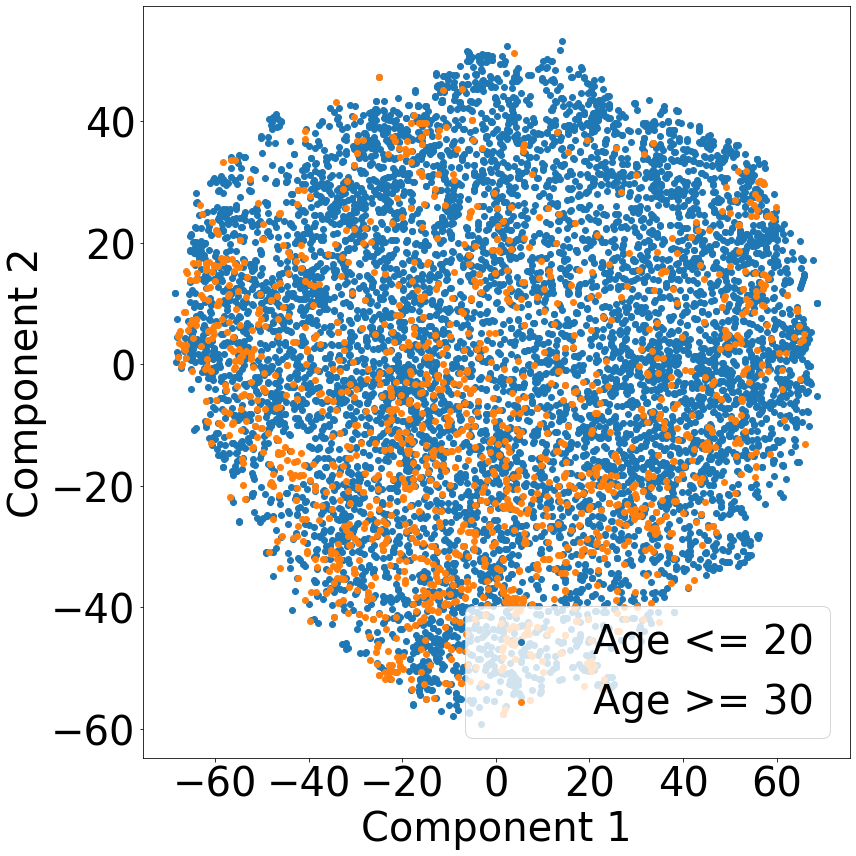

In [8]:
cur_key = 'age'
use_label = ['Age <= 20','Age >= 30']
plt.figure(figsize=(12,12))
fontsize=40
label = []
test_user_ids = Y_test[:,Y_columns['subId']]
for user in test_user_ids:
    cur_label = demo_dict['age_class'][user]
    label.append(cur_label)
label = np.array(label)
for c_label in use_label:
    cur_ids = np.where(label == c_label)[0]
    plt.scatter(X_reduced[cur_ids,0],X_reduced[cur_ids,1], label = c_label)
plt.legend(fontsize=fontsize)
plt.xlabel('Component 1',fontsize=fontsize)
plt.ylabel('Component 2',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig('plots/' + cur_key + '_t_sne.pdf')
plt.show()

### Visualize by Task

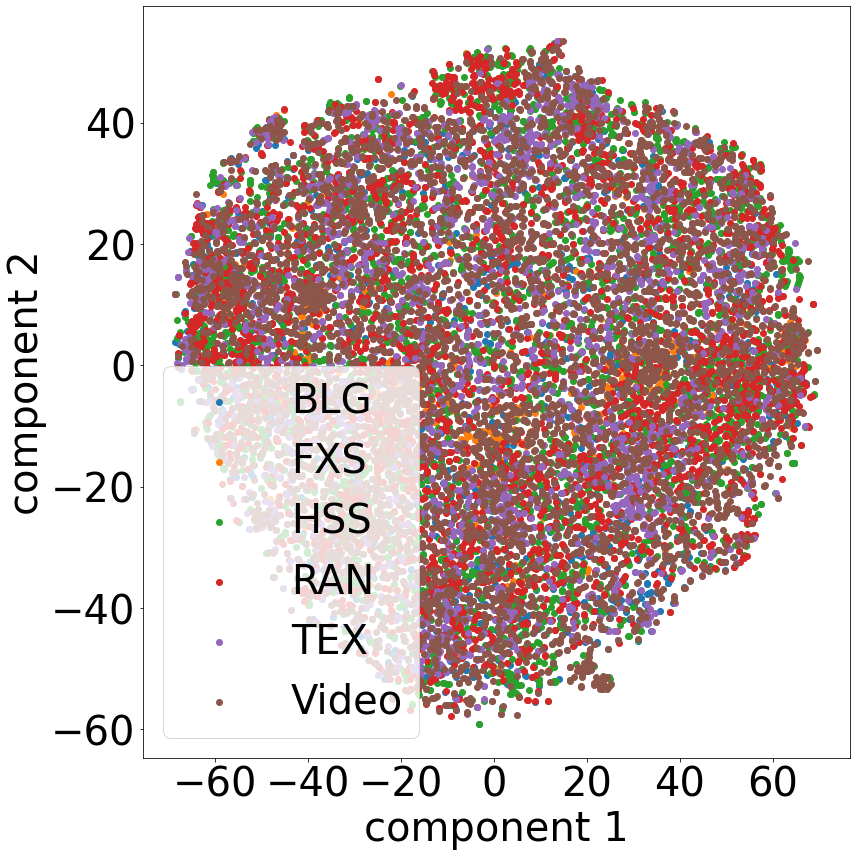

In [9]:
{'VD1': 0, 'VD2': 1, 'HSS': 2, 'FXS': 3, 'RAN': 4, 'TEX': 5, 'BLG': 6}
task_ids_mapping = {'Video':[0,1],
'HSS':[2],
'FXS':[3],
'RAN':[4],
'TEX':[5],
'BLG':[6]}

task_id_label_mapping = dict()
for key in task_ids_mapping:
    task_ids = task_ids_mapping[key]
    for task_id in task_ids:
        task_id_label_mapping[task_id] = key

cur_key = 'task'
plt.figure(figsize=(12,12))
fontsize=40
label = []
test_task_ids = Y_test[:,Y_columns['trial']]
for i in range(len(test_task_ids)):
    cur_label = test_task_ids[i]
    label.append(task_id_label_mapping[cur_label])
label = np.array(label)

use_label = list(np.unique(label))
for c_label in use_label:
    cur_ids = np.where(label == c_label)[0]
    show_label = c_label
    plt.scatter(X_reduced[cur_ids,0],X_reduced[cur_ids,1], label = show_label)
plt.legend(fontsize=fontsize)
plt.xlabel('component 1',fontsize=fontsize)
plt.ylabel('component 2',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig('plots/' + cur_key + '_t_sne.pdf')
plt.show()